CSC 820  
Homework 12  
Andrew Dahlstrom  
5/4/24  

In [3]:
# Import necessary libraries
import os
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Display directory contents
print(os.listdir("/content/drive/MyDrive/Colab Notebooks/CSC 820/HW 12"))
%matplotlib inline

['train.json', 'test.json', 'sample_submission.csv']


In [4]:
# Reading .json training and test sets into dataframes
data = pd.read_json('/content/drive/MyDrive/Colab Notebooks/CSC 820/HW 12/train.json')
test = pd.read_json('/content/drive/MyDrive/Colab Notebooks/CSC 820/HW 12/test.json')

In [5]:
# Display rows and columns of dataframes
print('Training data shape: {}'.format(data.shape))
print('Test data shape: {}'.format(test.shape))

Training data shape: (39774, 3)
Test data shape: (9944, 2)


In [6]:
# Target variable
target = data.cuisine

In [7]:
# Create a column to store the number of ingredients for each cuisine
data['ingredient_count'] = data['ingredients'].apply(len)

In [8]:
# Extract items from nested list and add it to resulting list
def flatten_lists(lst):
    """Remove nested lists."""
    return [item for sublist in lst for item in sublist]

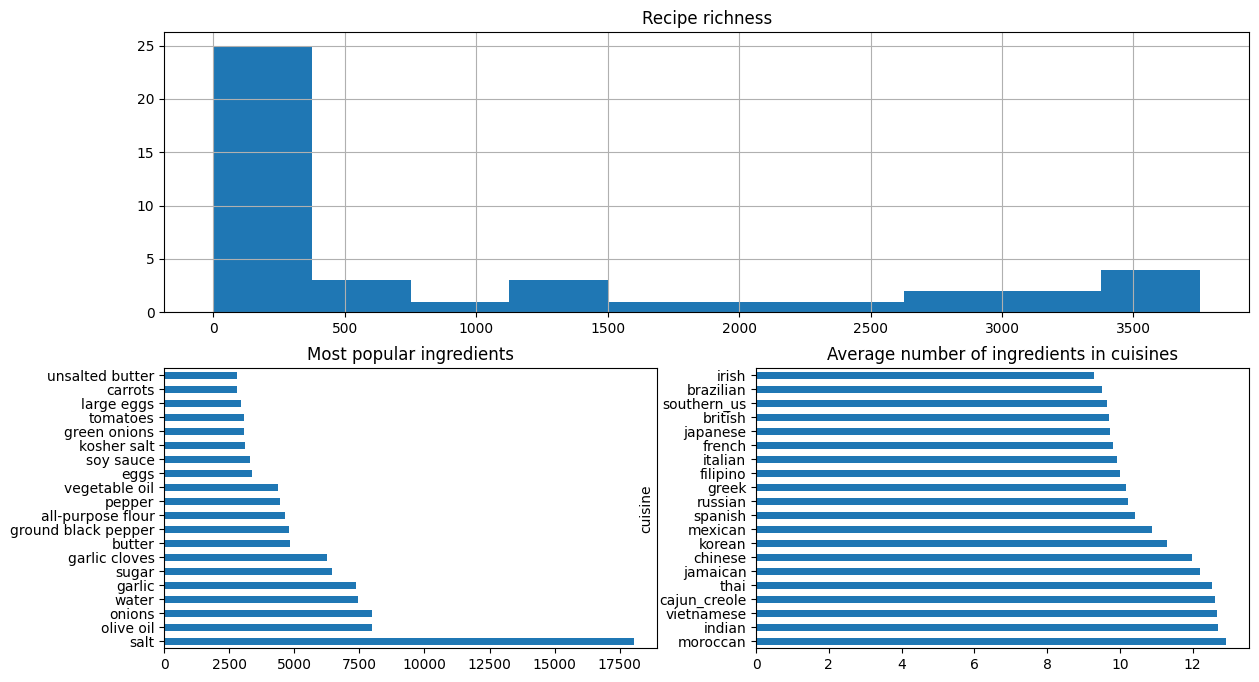

In [12]:
# Create a new figure with subplots
f = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(2, 2)

# Create a subplot for the histogram of the ingredient counts
ax1 = plt.subplot(gs[0, :])
data.ingredient_count.value_counts().hist(ax=ax1)
ax1.set_title('Recipe richness', fontsize=12)

# Create a subplot for the 20 most popular ingredients
ax2 = plt.subplot(gs[1, 0])
pd.Series(flatten_lists(list(data['ingredients']))).value_counts()[:20].plot(kind='barh', ax=ax2)
ax2.set_title('Most popular ingredients', fontsize=12)

# Calculate mean ingredient count per cuisine
mean_ingredient_counts = data.groupby('cuisine')['ingredient_count'].mean().sort_values(ascending=False)

# Create a third subplot for the mean ingredients per cuisine
ax3 = plt.subplot(gs[1, 1])
mean_ingredient_counts.plot(kind='barh', ax=ax3)
ax3.set_title('Average number of ingredients in cuisines', fontsize=12)

# Show plots
plt.show()

In [14]:
# Feed a word2vec with the ingredients
w2v = gensim.models.Word2Vec(list(data.ingredients), vector_size=350, window=10, min_count=2, epochs=20)

In [16]:
# Find the most similar words to 'meat' using Word2Vec
w2v.wv.most_similar('meat')

[('beef', 0.6992911696434021),
 ('pork', 0.6568830609321594),
 ('ground beef', 0.6286256313323975),
 ('chicken', 0.6236504912376404),
 ('pork chops', 0.5962822437286377),
 ('beef brisket', 0.5884971618652344),
 ('chicken meat', 0.5884231925010681),
 ('pork loin', 0.5828066468238831),
 ('boneless chicken breast', 0.5814295411109924),
 ('beef tongue', 0.5805979371070862)]

In [17]:
# Find the most similar words to 'chicken' using Word2Vec
w2v.wv.most_similar('chicken')

[('chicken breasts', 0.7730144262313843),
 ('boneless chicken breast', 0.7167215347290039),
 ('boneless skinless chicken breasts', 0.7121331095695496),
 ('chicken thighs', 0.7031248211860657),
 ('cooked chicken', 0.6523098945617676),
 ('boneless chicken skinless thigh', 0.6451770067214966),
 ('chicken pieces', 0.6389335989952087),
 ('meat', 0.6236504912376404),
 ('chicken meat', 0.6139611005783081),
 ('chicken legs', 0.5874641537666321)]

In [31]:
# Define function to create document vectors by removing out of vocabulary
# words then calculating the mean
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in w2v.wv.key_to_index]
    return np.mean([w2v.wv.get_vector(word) for word in doc], axis=0)

In [21]:
# Apply the document_vector function to each doc in 'ingredients' column
# of the training and test datasets
data['doc_vector'] = data.ingredients.apply(document_vector)
test['doc_vector'] = test.ingredients.apply(document_vector)

In [22]:
# Initialize a LabelEncoder and encode the target variable 'cuisine' using LabelEncoder
lb = LabelEncoder()
y = lb.fit_transform(target)

In [23]:
# Extract document vectors from training and test data
X = list(data['doc_vector'])
X_test = list(test['doc_vector'])

In [24]:
# Initialize a logistic regression classifier with regularization parameter C=100
clf = LogisticRegression(C=100)

In [25]:
# Fit the logistic regression classifier to training dataset
clf.fit(X, y)

LogisticRegression(C=100)

In [26]:
# Predict the test labels from the test predictors using the logistic regression classifier
y_test = clf.predict(X_test)
# Inverse transform the predicted labels to get original cuisine names
y_pred = lb.inverse_transform(y_test)

In [28]:
# Get test IDs
test_id = [id_ for id_ in test.id]
# Create DataFrame to hold test IDs and predicted cuisines
sub = pd.DataFrame({'id': test_id, 'cuisine': y_pred}, columns=['id', 'cuisine'])
#sub.to_csv('clf_output.csv', index=False)
# Print the first 10 rows of the test IDs and predicted cuisines
print(sub.head(10))

      id       cuisine
0  18009       british
1  28583        french
2  41580       italian
3  29752  cajun_creole
4  35687       italian
5  38527   southern_us
6  19666       spanish
7  41217       chinese
8  28753       mexican
9  22659       british


Dataset Citation  
Addison Howard, Wendy Kan. (2018). What's Cooking? (Kernels Only). Kaggle. https://kaggle.com/competitions/whats-cooking-kernels-only